Simple Linear Regression model
==============================
Most tutorials start with some nice and pretty image classification problem to illustrate how to use PyTorch. It may seem cool, but I believe it distracts you from the main goal: how PyTorch works?
For this reason, in this tutorial, I will stick with a simple and familiar problem: a linear regression with a single feature x! It doesn’t get much simpler than that…
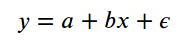
Data Generation
---------------
Let’s start generating some synthetic data: we start with a vector of 100 points for our feature x and create our labels using a = 1, b = 2 and some Gaussian noise.
Next, let’s split our synthetic data into train and validation sets, shuffling the array of indices and using the first 80 shuffled points for training.

In [5]:
%matplotlib inline

In [3]:
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

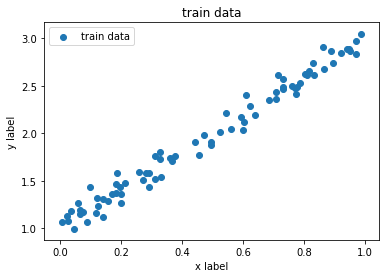

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x_train, y_train, label='train data')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("train data")
plt.legend()
plt.show()

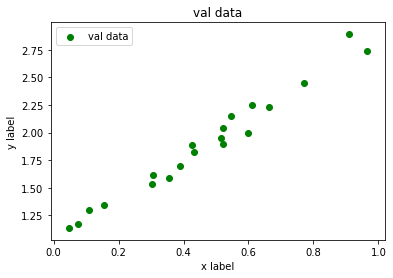

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x_val, y_val, label='val data',color='g')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title("val data")
plt.legend()
plt.show()

We know that a = 1 and b = 2, but now let’s see how close we can get to the true values by using gradient descent and the 80 points in the training set…

Gradient Descent
------------------------
I’ll cover the four basic steps you’d need to go through to compute it.  
Step 1: Compute the Loss
For a regression problem, the loss is given by the Mean Square Error (MSE), that is, the average of all squared differences between labels (y) and predictions (a + bx).
It is worth mentioning that, if we use all points in the training set (N) to compute the loss, we are performing a batch gradient descent. If we were to use a single point at each time, it would be a stochastic gradient descent. Anything else (n) in-between 1 and N characterizes a mini-batch gradient descent.
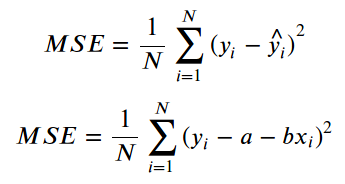
<center>Loss: Mean Squared Error (MSE)

Step 2: Compute the Gradients
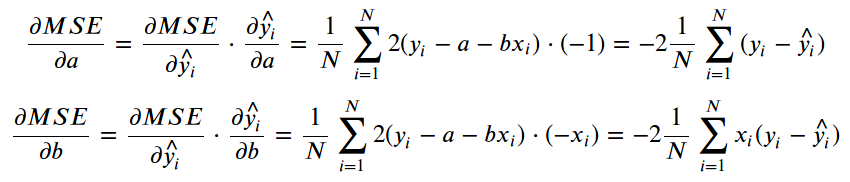   
A gradient is a partial derivative — why partial? Because one computes it with respect to (w.r.t.) a single parameter. We have two parameters, a and b, so we must compute two partial derivatives.
A derivative tells you how much a given quantity changes when you slightly vary some other quantity. In our case, how much does our MSE loss change when we vary each one of our two parameters?
The right-most part of the equations below is what you usually see in implementations of gradient descent for a simple linear regression. In the intermediate step, I show you all elements that pop-up from the application of the chain rule, so you know how the final expression came to be.
Computing gradients w.r.t coefficients a and b

Step 3: Update the Parameters  
In the final step, we use the gradients to update the parameters. Since we are trying to minimize our losses, we reverse the sign of the gradient for the update.
There is still another parameter to consider: the learning rate, denoted by the Greek letter eta (that looks like the letter n), which is the multiplicative factor that we need to apply to the gradient for the parameter update.

Updating coefficients a and b using computed gradients and a learning rate
How to choose a learning rate? That is a topic on its own and beyond the scope of this post as well.
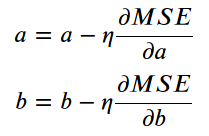

Step 4: Rinse and Repeat!  
Now we use the updated parameters to go back to Step 1 and restart the process.
An epoch is complete whenever every point has been already used for computing the loss. For batch gradient descent, this is trivial, as it uses all points for computing the loss — one epoch is the same as one update. For stochastic gradient descent, one epoch means N updates, while for mini-batch (of size n), one epoch has N/n updates.
Repeating this process over and over, for many epochs, is, in a nutshell, training a model.

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [16]:
# FIRST
# Initializes parameters "a" and "b" randomly, ALMOST as we did in Numpy
# since we want to apply gradient descent on these parameters, we need
# to set REQUIRES_GRAD = TRUE
a = torch.randn(1, requires_grad=True, dtype=torch.float)
b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(a, b)

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
a = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(a, b)
# Sorry, but NO! The to(device) "shadows" the gradient...

# THIRD
# We can either create regular tensors and send them to the device (as we did with our data)
a = torch.randn(1, dtype=torch.float).to(device)
b = torch.randn(1, dtype=torch.float).to(device)
# and THEN set them as requiring gradients...
a.requires_grad_()
b.requires_grad_()
print(a, b)

tensor([0.2379], requires_grad=True) tensor([0.0532], requires_grad=True)
tensor([-1.6788], device='cuda:0', grad_fn=<CopyBackwards>) tensor([0.8597], device='cuda:0', grad_fn=<CopyBackwards>)
tensor([-0.5159], device='cuda:0', requires_grad=True) tensor([0.3236], device='cuda:0', requires_grad=True)


In PyTorch, every method that ends with an underscore (_) makes changes in-place, meaning, they will modify the underlying variable.

Autograd is PyTorch’s automatic differentiation package. Thanks to it, we don’t need to worry about partial derivatives, chain rule or anything like it.  
So, how do we tell PyTorch to do its thing and compute all gradients? That’s what backward() is good for.
Do you remember the starting point for computing the gradients? It was the loss, as we computed its partial derivatives w.r.t. our parameters. Hence, we need to invoke the backward() method from the corresponding Python variable, like, loss.backward().
What about the actual values of the gradients? We can inspect them by looking at the grad attribute of a tensor.

In [24]:
lr = 1e-1
n_epochs = 1000
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.3881], device='cuda:0')
tensor([-1.9439], device='cuda:0')
tensor([-2.5268], device='cuda:0')
tensor([-1.5005], device='cuda:0')
tensor([-1.8796], device='cuda:0')
tensor([-1.1666], device='cuda:0')
tensor([-1.3935], device='cuda:0')
tensor([-0.9151], device='cuda:0')
tensor([-1.0283], device='cuda:0')
tensor([-0.7254], device='cuda:0')
tensor([-0.7541], device='cuda:0')
tensor([-0.5822], device='cuda:0')
tensor([-0.5483], device='cuda:0')
tensor([-0.4741], device='cuda:0')
tensor([-0.3938], device='cuda:0')
tensor([-0.3922], device='cuda:0')
tensor([-0.2780], device='cuda:0')
tensor([-0.3301], device='cuda:0')
tensor([-0.1912], device='cuda:0')
tensor([-0.2829], device='cuda:0')
tensor([-0.1262], device='cuda:0')
tensor([-0.2469], device='cuda:0')
tensor([-0.0777], device='cuda:0')
tensor([-0.2193], device='cuda:0')
tensor([-0.0414], device='cuda:0')
tensor([-0.1981], device='cuda:0')
tensor([-0.0144], device='cuda:0')
tensor([-0.1816], device='cuda:0')
tensor([0.0056], dev

tensor([-0.0259], device='cuda:0')
tensor([0.0130], device='cuda:0')
tensor([-0.0255], device='cuda:0')
tensor([0.0128], device='cuda:0')
tensor([-0.0251], device='cuda:0')
tensor([0.0126], device='cuda:0')
tensor([-0.0247], device='cuda:0')
tensor([0.0125], device='cuda:0')
tensor([-0.0244], device='cuda:0')
tensor([0.0123], device='cuda:0')
tensor([-0.0240], device='cuda:0')
tensor([0.0121], device='cuda:0')
tensor([-0.0236], device='cuda:0')
tensor([0.0119], device='cuda:0')
tensor([-0.0233], device='cuda:0')
tensor([0.0117], device='cuda:0')
tensor([-0.0229], device='cuda:0')
tensor([0.0115], device='cuda:0')
tensor([-0.0226], device='cuda:0')
tensor([0.0114], device='cuda:0')
tensor([-0.0222], device='cuda:0')
tensor([0.0112], device='cuda:0')
tensor([-0.0219], device='cuda:0')
tensor([0.0110], device='cuda:0')
tensor([-0.0216], device='cuda:0')
tensor([0.0109], device='cuda:0')
tensor([-0.0212], device='cuda:0')
tensor([0.0107], device='cuda:0')
tensor([-0.0209], device='cuda:0')

tensor([-0.0039], device='cuda:0')
tensor([0.0020], device='cuda:0')
tensor([-0.0039], device='cuda:0')
tensor([0.0019], device='cuda:0')
tensor([-0.0038], device='cuda:0')
tensor([0.0019], device='cuda:0')
tensor([-0.0037], device='cuda:0')
tensor([0.0019], device='cuda:0')
tensor([-0.0037], device='cuda:0')
tensor([0.0019], device='cuda:0')
tensor([-0.0036], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0036], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0035], device='cuda:0')
tensor([0.0018], device='cuda:0')
tensor([-0.0035], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0034], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0034], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0033], device='cuda:0')
tensor([0.0017], device='cuda:0')
tensor([-0.0033], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0032], device='cuda:0')
tensor([0.0016], device='cuda:0')
tensor([-0.0032], device='cuda:0')

tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0005], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0005], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0005], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0005], device='cuda:0')
tensor([0.0003], device='cuda:0')
tensor([-0.0005], device='cuda:0')

KeyboardInterrupt: 

In [25]:
lr

0.1

Optimizer
---------
So far, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like SGD or Adam.
An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its step() method.
Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s zero_grad() method and that’s it!
In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters a and b.
Don’t be fooled by the optimizer’s name: if we use all training data at once for the update — as we are actually doing in the code — the optimizer is performing a batch gradient descent, despite of its name.

In [19]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)
